<a href="https://colab.research.google.com/github/jalonsomoya/FSCLogs/blob/master/ALS_WS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Instalación y configuración de librerías y módulos


In [3]:
# General packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Install pyspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.uvigo.es/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar -xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark pyspark==2.4.8

# Import modules
import findspark
from pyspark.sql import SparkSession, functions as F
from pyspark.ml import Pipeline
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, DecimalType
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Set enviroment variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()


### Acceso a los datos compartidos vía Drive

---



In [4]:
# Permitir acceso a contenido compartido de Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Introduce the current path of the shared file Ratings WS.zip
path = './drive/My Drive/Colab Notebooks/'

In [6]:
# Reading CSV file
pd_data_raw = pd.read_csv(path+'Ratings WS_WSeason.zip', sep='\t',
                            encoding = 'UTF-8-SIG', engine = 'python', decimal=',')

print('Number of rating records: ' + str(len(pd_data_raw)))
print('Total of users: ' + str(pd_data_raw.USER_ID.nunique()))
print('Total of patterns: ' + str(pd_data_raw.patron.nunique()))

pd_data_raw.rename(columns={"patron":"PATRON"},inplace=True)

Number of rating records: 1650227
Total of users: 421590
Total of patterns: 4085


### Tratamiento de datos


---




Transformar los usuarios y los items en enteros consecutivos sin duplicados

In [7]:
pd_user = pd.DataFrame(pd_data_raw["USER_ID"])
pd_user.drop_duplicates(inplace=True)
pd_user['rowid'] = pd_user.reset_index().index+1
pd_user

,USER_ID,rowid
0,526921,1
1,971890,2
2,2712279,3
3,1659469,4
4,1184805,5
...,...,...
1650118,1046016,421586
1650122,2882297,421587
1650124,378108,421588
1650132,1115390,421589


In [8]:
pd_pat = pd.DataFrame(pd_data_raw["PATRON"])
pd_pat.drop_duplicates(inplace=True)
pd_pat['rowid2'] = pd_pat.reset_index().index+1
pd_pat

,PATRON,rowid2
0,7899645,1
1,4039661,2
2,4858530,3
3,4667662,4
4,4509870,5
...,...,...
1647225,4998871,4081
1649401,3549283,4082
1649482,4217470,4083
1649731,4847555,4084


Aplicar los cambios y renombrar las columnas

In [9]:
pd_data_raw = pd.merge(pd_data_raw, pd_user, on='USER_ID',how='left')
pd_data_raw = pd.merge(pd_data_raw, pd_pat, on='PATRON',how='left')
pd_data_raw.rename(columns={"rowid":"user"},inplace=True)
pd_data_raw.rename(columns={"rowid2":"patron"},inplace=True)

pd_data_raw.head()

,USER_ID,PATRON,rating,user,patron
0,526921,7899645,9.5,1,1
1,971890,4039661,9.5,2,2
2,2712279,4858530,7.0,3,3
3,1659469,4667662,9.5,4,4
4,1184805,4509870,9.5,5,5


In [10]:
pd_data_WS = pd.merge(pd_data_raw, pd_user, on='USER_ID',how='left')
pd_data_WS = pd.merge(pd_data_WS, pd_pat, on='PATRON',how='left')
pd_data_WS.rename(columns={"RATING":"rating"},inplace=True)
pd_data_WS = pd_data_WS[['rowid','rowid2','rating']]
pd_data_WS.rename(columns={"rowid":"user"},inplace=True)
pd_data_WS.rename(columns={"rowid2":"patron"},inplace=True)
pd_data_WS

,user,patron,rating
0,1,1,9.5
1,2,2,9.5
2,3,3,7.0
3,4,4,9.5
4,5,5,9.5
...,...,...,...
1650222,32927,4085,9.5
1650223,327965,4085,9.5
1650224,349444,4085,7.0
1650225,12144,4085,9.5


Crear las columnas de Items y Ratings


In [11]:
pd_items = pd_data_WS[['patron','rating']] \
                .groupby(['patron'])['rating'] \
                .mean().reset_index(name='rating') \
                .sort_values('rating', ascending =False)
pd_items

,patron,rating
155,156,10.00
2433,2434,9.75
1390,1391,9.75
2278,2279,9.75
3403,3404,9.75
...,...,...
1156,1157,7.00
739,740,7.00
3172,3173,7.00
1778,1779,7.00


In [12]:
pd_ratings = pd_data_WS[['user','patron','rating']]
pd_ratings['rating'] = pd_ratings[['rating']].astype(float)
pd_ratings

,user,patron,rating
0,1,1,9.5
1,2,2,9.5
2,3,3,7.0
3,4,4,9.5
4,5,5,9.5
...,...,...,...
1650222,32927,4085,9.5
1650223,327965,4085,9.5
1650224,349444,4085,7.0
1650225,12144,4085,9.5


### Spark DataFrame


---



Definir la estructura para el SparkDataFrame

In [15]:
# Ratings structure
schema = StructType([StructField("user", IntegerType(), True),
                     StructField("patron", IntegerType(), True),
                     StructField("rating", DoubleType(), True)])

df_ratings = spark.createDataFrame(pd_ratings, schema=schema)
df_ratings.show(25)

+----+------+------+
|user|patron|rating|
+----+------+------+
|   1|     1|   9.5|
|   2|     2|   9.5|
|   3|     3|   7.0|
|   4|     4|   9.5|
|   5|     5|   9.5|
|   6|     6|   9.5|
|   7|     7|   9.5|
|   8|     8|   9.5|
|   9|     9|   9.5|
|  10|    10|   9.5|
|  11|    11|   9.5|
|  12|    12|   7.0|
|  13|    13|   9.5|
|  14|    14|  10.0|
|  15|    15|   7.0|
|  16|    16|   9.5|
|  17|    17|   9.5|
|  18|    18|   9.5|
|  19|    19|   9.5|
|  20|    20|   9.5|
|  21|    21|   9.5|
|  22|    22|   9.5|
|  23|    23|   9.5|
|  24|    24|   9.5|
|  25|    25|   9.5|
+----+------+------+
only showing top 25 rows



In [16]:
def get_mat_sparsity(ratings):
    # Count the total number of ratings in the dataset
    count_nonzero = df_ratings.select("rating").count()

    # Count the number of distinct userIds and distinct movieIds
    total_elements = df_ratings.select("user").distinct().count() * df_ratings.select("patron").distinct().count()

    # Divide the numerator by the denominator
    sparsity = (1.0 - (count_nonzero *1.0)/total_elements)*100
    print("The ratings dataframe is ", "%.4f" % sparsity + "% sparse.")
    
get_mat_sparsity(df_ratings)

The ratings dataframe is  99.9042% sparse.


In [ ]:
# Items structure
schema = StructType([StructField("patron", IntegerType(), True),
                     StructField("rating", DoubleType(), True)])

df_items = spark.createDataFrame(pd_items, schema=schema)
df_items.show(5, False)

+------+-----------------+
|patron|rating           |
+------+-----------------+
|2951  |9.75             |
|7204  |9.7              |
|9638  |9.666666666666666|
|4757  |9.666666666666666|
|6771  |9.642857142857142|
+------+-----------------+
only showing top 5 rows



In [ ]:
# Normalize rating column
min_rating = 0
max_rating = 10
df_ratings = df_ratings.withColumn('norm_rating', (df_ratings.rating-min_rating)/(max_rating-min_rating))
df = df_ratings\
     .select("user","patron","norm_rating")\
     .withColumnRenamed("norm_rating", "label")
df.show(5)

+----+------+-----+
|user|patron|label|
+----+------+-----+
|   1|     1| 0.95|
|   2|     2| 0.95|
|   3|     3| 0.95|
|   4|     4| 0.95|
|   5|     5| 0.95|
+----+------+-----+
only showing top 5 rows



### ALS Model

Split & training the model

In [ ]:
(training, test) = df.randomSplit([0.8, 0.2])
cv_data = training.withColumnRenamed("rating", "label")

In [ ]:
cv_data.show(5)

+----+------+-----+
|user|patron|label|
+----+------+-----+
|   1|     1| 0.95|
|   1|   762| 0.95|
|   1|   975| 0.95|
|   1|  1343| 0.95|
|   1|  1464| 0.95|
+----+------+-----+
only showing top 5 rows



**Note: ** This execution is optional, user could skip it with no further issues in next cells.

*We tried many hyperparams grids and we choose the ones who minimize the Root-mean-square error (RMSE) evaluator. There is an example of Tuning selecting orientative params. Few cells later we'll be able to extract which params were the best.
Due to the duration of the ml tuning, we set a "beep" alert when the execution finish*

In [ ]:
# Set model
als = ALS(userCol="user", itemCol="patron", ratingCol="label", seed=0, nonnegative=True)

# Set considered parameter grid
paramGrid = ParamGridBuilder().addGrid(als.regParam, [0.15, 0.18, 0.2]) \
                              .addGrid(als.maxIter, [15, 20]) \
                              .addGrid(als.rank, [ 8, 10, 15, 20]).build()

# Set evaluator
modelEvaluator = RegressionEvaluator(metricName="rmse")
# Set cross validator instance
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=modelEvaluator,
                          numFolds=10)

# Perform cross-validation
cvModel = crossval.fit(cv_data)

best_als_model = cvModel.bestModel

print("Best number of latent factors (rank parameter): " + str(best_als_model.rank))
print("Best value of regularization factor: " + str(best_als_model._java_obj.parent().getRegParam()))
print("Max Iterations: " + str(best_als_model._java_obj.parent().getMaxIter()))

import time
time.sleep(2)

# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
%%time
(training, test) = cv_data.randomSplit([0.8, 0.2])
# Entrenamos con training set
als = ALS(maxIter=15, regParam=0.15, rank=10, userCol="user",
          itemCol="patron", ratingCol="label", seed=0, nonnegative=True)

model = als.fit(training)
predictions = model.transform(test)



CPU times: user 75.7 ms, sys: 19.4 ms, total: 95.1 ms
Wall time: 2min 15s


Testing and evaluation

In [ ]:
# Evaluate model's performance on test (evaluate overfitting)
def test_evaluation(predictions):
    # Model evaluation in test - ratings regression evaluation
    print("Model evaluation on test data:")
    predictions = predictions.na.drop()
    
    # RMSE
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction")
    rmse = rmse_evaluator.evaluate(predictions)
    print("Root-mean-square error (RMSE) = " + str(rmse))
    # MSE
    mse_evaluator = RegressionEvaluator(metricName="mse", labelCol="label", predictionCol="prediction")
    mse = mse_evaluator.evaluate(predictions)
    print("Mean-square error (MSE) = " + str(mse))
    # MAE
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="label", predictionCol="prediction")
    mae = mae_evaluator.evaluate(predictions)
    print("Mean Absolute Error (MAE) = " + str(mae))
    
    return [rmse, mse, mae]


In [ ]:
test_evaluation(predictions)

Model evaluation on test data:
Root-mean-square error (RMSE) = 0.15804901860726323
Mean-square error (MSE) = 0.02497949228271904
Mean Absolute Error (MAE) = 0.1548839434325815


[0.15804901860726323, 0.02497949228271904, 0.1548839434325815]

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


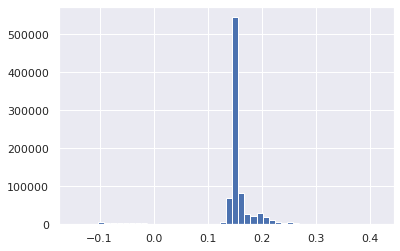

In [ ]:
pd_predictions = predictions.withColumn('dif', F.col('label')-F.col('prediction')).toPandas()
plt.hist(pd_predictions.dif, bins=50)
plt.show()

### Web exploring and examples

In [ ]:
# Make predictions on a random test subset obtained through randomSplit()

print("Predictions based on a random test subset:")
predictions.show(5)

Predictions based on a random test subset:
+-----+------+-----+----------+
| user|patron|label|prediction|
+-----+------+-----+----------+
|67225|   148| 0.95| 0.7960386|
|33200|   148| 0.95|0.79361826|
|36554|   148| 0.95|0.79674613|
|66668|   148| 0.95| 0.7980458|
|22834|   148| 0.95| 0.7970642|
+-----+------+-----+----------+
only showing top 5 rows



Top 5 recomendations for each user





In [ ]:
userRecs = model.recommendForAllUsers(5) 

In [ ]:
userRecs.show(1, truncate = False)

+----+------------------------------------------------------------------------------------------------+
|user|recommendations                                                                                 |
+----+------------------------------------------------------------------------------------------------+
|148 |[[5592, 0.8437624], [8045, 0.8355928], [2951, 0.83432484], [7204, 0.8321394], [9638, 0.8277186]]|
+----+------------------------------------------------------------------------------------------------+
only showing top 1 row



To show purchase and recomendations examples, lets take my own user_id (234565). Remember that we must look into our original pandas DataFrame users

In [ ]:
exm = pd_user[pd_user['USER_ID']==234565]
exm

,USER_ID,rowid
290356,234565,199762


In [ ]:
myrecomendations = userRecs.filter(F.col('user')==199762)

In [ ]:
myrecomendations.show(truncate = False)

+------+-------------------------------------------------------------------------------------------------+
|user  |recommendations                                                                                  |
+------+-------------------------------------------------------------------------------------------------+
|199762|[[5592, 0.84171295], [8045, 0.8335633], [2951, 0.8322984], [7204, 0.83011836], [9638, 0.8257082]]|
+------+-------------------------------------------------------------------------------------------------+



In [ ]:
pd_myrecs = pd_pat[pd_pat['rowid2'].isin([5592, 8045, 2951, 7204, 9638])]
pd_myrecs

,PATRON,rowid2
1350850,5358841,2951
2644269,5359422,5592
3416725,8328242,7204
3815537,3062260,8045
4620979,3598772,9638


In [ ]:
pd_mypurchases = pd_data_raw[pd_data_raw['USER_ID']==199762]
pd_mypurchases

,USER_ID,PATRON,rating,user,patron
458898,199762,5986397,9.5,277009,808
787541,199762,5996198,9.5,277009,1585
1030048,199762,5985323,9.5,277009,2199
1255536,199762,4345649,9.5,277009,2643
2252843,199762,7682867,9.5,277009,4317
3099693,199762,5987822,9.5,277009,6499
3308921,199762,5545463,9.5,277009,6859
3576664,199762,5996260,9.5,277009,7524
4115606,199762,7915306,9.5,277009,8647
4259410,199762,5997941,9.5,277009,8868


https://womensecret.com/es/es/search?q=7682867

https://womensecret.com/es/es/search?q=5987822


